<a href="https://colab.research.google.com/github/joanby/tensorflow2/blob/master/Collab%2012%20-%20Crear%20una%20API%20para%20Clasificar%20Imágenes%20con%20TensorFlow%20Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paso 1: Instalar las dependencias y configurar el proyecto en GPU


In [21]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   143k      0 --:--:-- --:--:-- --:--:--  143k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/

In [22]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 210 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.3.0 [210 MB]
Fetched 210 MB in 4s (50.4 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144618 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.3.0_all.deb ...
Unpacking tensorflow-model-server (2.3.0) ...
Setting up tensorflow-model-server (2.3.0) ...


In [23]:
#!pip install tensorflow-gpu==1.13.1

In [24]:
!pip install requests

## Paso 2: Importar las dependencias del proyecto

In [25]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'2.3.0'

## Paso 3: Pre procesado de los datos

### Cargar el dataset

In [26]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [27]:
class_names = ['avión', 'coche', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

### Normalización de imágenes

In [28]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [29]:
X_train.shape

(50000, 32, 32, 3)

## Paso 4: Definir el modelo

NOTA: Vamos a usar el mismo modelo que creamos en la Sección de Redes Neuronales Convolucionales

In [30]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

### Compilar el modelo

In [31]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

###  Entrenar el modelo

In [32]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
391/391 [==============================] - 3s 6ms/step - loss: 1.4902 - sparse_categorical_accuracy: 0.4621
Epoch 2/10
391/391 [==============================] - 2s 6ms/step - loss: 1.0557 - sparse_categorical_accuracy: 0.6277
Epoch 3/10
391/391 [==============================] - 3s 6ms/step - loss: 0.8649 - sparse_categorical_accuracy: 0.6989
Epoch 4/10
391/391 [==============================] - 3s 6ms/step - loss: 0.7352 - sparse_categorical_accuracy: 0.7451
Epoch 5/10
391/391 [==============================] - 3s 6ms/step - loss: 0.6386 - sparse_categorical_accuracy: 0.7763
Epoch 6/10
391/391 [==============================] - 3s 6ms/step - loss: 0.5608 - sparse_categorical_accuracy: 0.8033
Epoch 7/10
391/391 [==============================] - 3s 6ms/step - loss: 0.4823 - sparse_categorical_accuracy: 0.8305
Epoch 8/10
391/391 [==============================] - 3s 6ms/step - loss: 0.4110 - sparse_categorical_accuracy: 0.8541
Epoch 9/10
391/391 [============================

### Evaluar el modelo

In [33]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.9225 - sparse_categorical_accuracy: 0.7407


In [34]:
print("La precisión del modelo es de {} %".format(test_accuracy*100.0))

La precisión del modelo es de 74.07000064849854 %


## Paso 5: Guardar el modelo para subir a producción

### Crear un directorio para el modelo

In [15]:
MODEL_DIR = "model/"
version = 1

In [16]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [17]:
if os.path.isdir(export_path):
    !rm -r {export_path}

### Guardar el modelo para TensorFlow Serving

In [35]:
#tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})
#tf.saved_model.save(model, export_path )
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = model/1

INFO:tensorflow:Assets written to: model/1/assets

Saved model:
total 180
drwxr-xr-x 2 root root   4096 Oct  5 17:21 assets
-rw-r--r-- 1 root root 173410 Oct  5 17:29 saved_model.pb
drwxr-xr-x 2 root root   4096 Oct  5 17:29 variables


## Paso 6: Configurar el entorno de producción

### Exportar el MODEL_DIR a las variables de entorno

In [36]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Ejecutar la API REST de TensorFlow Serving

In [37]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8000 \
  --model_name=cifar10 \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [38]:
!tail server.log

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-10-05 17:29:41.103709: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:199] Restoring SavedModel bundle.
2020-10-05 17:29:41.144999: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /content/model/1
2020-10-05 17:29:41.150494: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:303] SavedModel load for tags { serve }; Status: success: OK. Took 64753 microseconds.
2020-10-05 17:29:41.151288: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2020-10-05 17:29:41.151386: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cifar10 version: 1}
2020-10-05 17:29:41.152351: I tensorflow_serving/model_servers/server.cc:367] Running gRPC ModelServer at 0.0.0.

## Paso 7: Crear nuestra primera petición por POST

In [39]:
random_image = np.random.randint(0, len(X_test))
random_image

6148

### Crear el objeto de datos en JSON

In [40]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [41]:
data

'{"signature_name": "serving_default", "instances": [[[[0.47843137254901963, 0.5372549019607843, 0.4549019607843137], [0.5529411764705883, 0.611764705882353, 0.5294117647058824], [0.4470588235294118, 0.5058823529411764, 0.4196078431372549], [0.403921568627451, 0.4666666666666667, 0.3803921568627451], [0.44313725490196076, 0.5058823529411764, 0.42745098039215684], [0.39215686274509803, 0.4588235294117647, 0.3764705882352941], [0.27058823529411763, 0.33725490196078434, 0.25882352941176473], [0.19215686274509805, 0.2549019607843137, 0.16470588235294117], [0.19215686274509805, 0.2549019607843137, 0.14901960784313725], [0.20392156862745098, 0.27450980392156865, 0.16862745098039217], [0.30980392156862746, 0.396078431372549, 0.29411764705882354], [0.34509803921568627, 0.42745098039215684, 0.3176470588235294], [0.3764705882352941, 0.44313725490196076, 0.30980392156862746], [0.3803921568627451, 0.44313725490196076, 0.33725490196078434], [0.3411764705882353, 0.4, 0.3137254901960784], [0.35294117

### Enviar la primera petición POST al modelo

In [42]:
headers = {"content-type":"application/json"}

In [43]:
json_response = requests.post(url="http://localhost:8000/v1/models/cifar10:predict", data=data, headers=headers)

In [44]:
json_response

<Response [200]>

In [45]:
predictions = json.loads(json_response.text)['predictions']

In [46]:
predictions

[[0.000112434522,
  2.91902029e-06,
  0.049065,
  0.0013105449,
  0.732287228,
  0.000415284157,
  0.21677956,
  2.10254038e-05,
  1.86315174e-06,
  4.12425061e-06]]

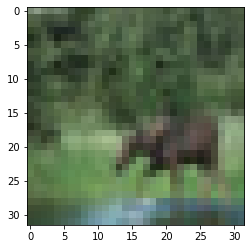

In [47]:
plt.imshow(X_test[random_image])

In [48]:
class_names[np.argmax(predictions[0])]

'ciervo'

## Paso 8: Enviar una petición POST a un modelo específico 

In [49]:
specific_json_response = requests.post(url="http://localhost:8000/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [50]:
specific_json_response

<Response [200]>